In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, GlobalAveragePooling2D, RandomRotation
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121
from sklearn.model_selection import StratifiedKFold
from classification_models.keras import Classifiers


import tensorflow as tf
import sklearn

NUMBER_CLASSES = 4

In [7]:
def create_resnet_model(image_size):
    # base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    # base_model.trainable = True
    
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = True
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [8]:
def create_resnet_model_horizontal_flip(image_size):
    # base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    # base_model.trainable = False
    
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = True
    
    model = Sequential()
    model.add(tf.keras.layers.RandomFlip(mode='horizontal'))
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [9]:
def create_resnet_model_vertical_flip(image_size):
    # base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    # base_model.trainable = False
    
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = True
    
    model = Sequential()
    model.add(tf.keras.layers.RandomFlip(mode='vertical'))
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [27]:
def create_resnet_model_rotation(image_size):
    # base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    # base_model.trainable = False
    
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = True
    
    model = Sequential()
    model.add(tf.keras.layers.RandomRotation(0.0417, fill_mode='constant', fill_value=0.0))
    model.add(tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'))
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [10]:
def create_resnet_model_translation(image_size):
    # base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    # base_model.trainable = False
    
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = True
    
    model = Sequential()
    model.add(tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode='constant', fill_value=0.0))
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [29]:
def create_resnet_model_all_geometric(image_size):
    # base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    # base_model.trainable = False
    
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = True
    
    model = Sequential()
    model.add(tf.keras.layers.RandomRotation(0.0417, fill_mode='constant', fill_value=0.0))
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [11]:
class RandomCornerCropLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RandomCornerCropLayer, self).__init__(**kwargs)

    def call(self, inputs):
        image_height, image_width, _ = inputs.shape[1:]
    
        crops = {
            'top_left': (0, 0),
            'top_right': (0, image_width - 224),
            'bottom_left': (image_height - 224, 0),
            'bottom_right': (image_height - 224, image_width - 224),
            'center': ((image_height - 224) // 2, (image_width - 224) // 2)
        }
    
        crop_position = np.random.choice(list(crops.keys()))        
        start_y, start_x = crops[crop_position]
        cropped_image = inputs[:, start_y:start_y + 224, start_x:start_x + 224, :]
    
        return cropped_image

def create_resnet_model_crop(image_size):
    # base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    # base_model.trainable = False
    
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = True
    
    model = Sequential()
    model.add(RandomCornerCropLayer())
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

# with open(f"augmentation_data/images_clean_20000_256.pkl", "rb") as file:
#     birne = pickle.load(file)[:10]
#     
# hh = RandomCornerCropLayer()
# birnen = hh.call(birne)
#     
# for i, sub_birne in enumerate(birne):
#     cv2.imwrite(f'TEST{i}.png', birne[i])
#     apfel = birnen[i]
#     cv2.imwrite(f'TEST{i}_adjusted.png', apfel)
#     print(apfel.shape)

In [7]:
IMAGE_SIZE = 224
IMAGE_CENTER = (IMAGE_SIZE // 2, IMAGE_SIZE // 2)

def normalize_image(img, label):
    img = tf.cast(img, np.float32)# / 255.0
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, label

# def normalize_image_horizontal(img, label):
#     img = tf.image.random_flip_left_right(img)
#     img = tf.cast(img, np.float32)# / 255.0
#     img = tf.keras.applications.resnet.preprocess_input(img)
#     return img, label
# 
# def normalize_image_vertical(img, label):
#     img = tf.image.random_flip_up_down(img)
#     img = tf.cast(img, np.float32)# / 255.0
#     img = tf.keras.applications.resnet.preprocess_input(img)
#     return img, label

def create_train_dataset(images_train, labels_train, batch_size=16):
    train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    train_dataset = train_dataset.map(normalize_image)
    train_dataset = train_dataset.shuffle(buffer_size=100)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.repeat()
    return train_dataset

def create_val_dataset(images_val, labels_val, batch_size=16):
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
    return val_dataset

In [8]:
def evaluate_model(model, images_test, labels_test, batch_size=16):

    # images_test_2 = tf.cast(images_test, np.float32)
    images_test_2 = []
    
    for sample in images_test:
        images_test_2.append(normalize_image(sample, None)) 
    
    images_test_2 = np.array([tensor[0].numpy() for tensor in images_test_2])
    
    predictions = model.predict(images_test_2, batch_size=batch_size)
    
    auc_per_class = []
    
    for class_idx in range(NUMBER_CLASSES):
        true_labels_class = labels_test[:, class_idx]
        
        auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions[:, class_idx])
        auc_per_class.append(auc)
        
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels_test, axis=1)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(true_classes, predicted_classes)
    accuracy = sklearn.metrics.accuracy_score(true_classes, predicted_classes)
    
    return auc_per_class, balanced_accuracy, accuracy

In [15]:
BATCH_SIZE = 16
NUMBER_OF_IMAGES = 20000
IMAGE_SIZE = 224
evaluations={}

with open(f"augmentation_data/images_clean.pkl", "rb") as file:
    images_clean = pickle.load(file)[:100]
with open(f"augmentation_data/labels_clean.pkl", "rb") as file:
    labels_clean = pickle.load(file)[:100]
with open(f"augmentation_data/images_test.pkl", "rb") as file:
    images_test = pickle.load(file)[:100]
with open(f"augmentation_data/labels_test.pkl", "rb") as file:
    labels_test = pickle.load(file)[:100]

In [ ]:
with open(f"augmentation_data/images_horizontal_flip.pkl", "rb") as file:
    images_horizontal_flip = pickle.load(file)
with open(f"augmentation_data/images_horizontal_flip.pkl", "rb") as file:
    images_vertical_flip = pickle.load(file)
with open(f"augmentation_data/images_rotation.pkl", "rb") as file:
    images_rotation = pickle.load(file)
with open(f"augmentation_data/images_crop.pkl", "rb") as file:
    images_crop = pickle.load(file)

In [11]:
with open(f"augmentation_data/images_clean_20000.pkl", "rb") as file:
    images_train = pickle.load(file)[:10000]
with open(f"augmentation_data/labels_clean_20000.pkl", "rb") as file:
    labels_train = pickle.load(file)[:10000]

with open(f"augmentation_data/images_val_2000.pkl", "rb") as file:
    images_val = pickle.load(file)
with open(f"augmentation_data/labels_val_2000.pkl", "rb") as file:
    labels_val = pickle.load(file)
val_dataset = create_val_dataset(images_val, labels_val)

with open(f"augmentation_data/images_test_4000.pkl", "rb") as file:
    images_test = pickle.load(file)
with open(f"augmentation_data/labels_test_4000.pkl", "rb") as file:
    labels_test = pickle.load(file)
    
master_evaluations = {}
BATCH_SIZE = 16
IMAGE_SIZE = 224

# for aug_idx in [0, 1, 2, 3, 4]:
for aug_idx in [6]:
    
    if aug_idx == 4:
        with open(f"augmentation_data/images_clean_20000_256.pkl", "rb") as file:
            images_train = pickle.load(file)[:10000]
    
    evaluations = {}
    
    for run in range(5):
    
        tf.keras.backend.clear_session()
           
        train_dataset = create_train_dataset(images_train, labels_train)
        
        steps_per_epoch = len(images_train) // BATCH_SIZE
        validation_steps = len(images_val) // BATCH_SIZE
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        reduceLR_callback = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=3,
            min_lr=1e-7
        )
        
        model = None
        
        if aug_idx == 0:
            model = create_resnet_model(IMAGE_SIZE)
        if aug_idx == 1:
            model = create_resnet_model_horizontal_flip(IMAGE_SIZE)
        if aug_idx == 2:
            model = create_resnet_model_vertical_flip(IMAGE_SIZE)
        if aug_idx == 3:
            model = create_resnet_model_rotation(IMAGE_SIZE)
        if aug_idx == 4:
            model = create_resnet_model_crop(IMAGE_SIZE)
        if aug_idx == 5:
            model = create_resnet_model_all_geometric(IMAGE_SIZE)
        if aug_idx == 6:
            model = create_resnet_model_translation(IMAGE_SIZE)
                            
        model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=20,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            batch_size=BATCH_SIZE,
            verbose=1,
            callbacks=[early_stopping]) #######BIRNE
        
        sub_eval = evaluate_model(model, images_test, labels_test)
        
        evaluations[run] = sub_eval
        print(aug_idx)
        print(evaluations)
        
    master_evaluations[aug_idx] = evaluations

Epoch 1/20


2025-04-03 11:42:54.857169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 179s 265ms/step - auc: 0.6535 - loss: 0.9549 - val_auc: 0.7319 - val_loss: 0.8074
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 159s 255ms/step - auc: 0.7212 - loss: 0.8398 - val_auc: 0.7170 - val_loss: 0.8229
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 160s 256ms/step - auc: 0.7598 - loss: 0.7977 - val_auc: 0.7290 - val_loss: 0.8362
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 252ms/step - auc: 0.8040 - loss: 0.7331 - val_auc: 0.7430 - val_loss: 0.8070
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 160s 255ms/step - auc: 0.8367 - loss: 0.6819 - val_auc: 0.6977 - val_loss: 0.9872
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 163s 261ms/step - auc: 0.8672 - loss: 0.6231 - val_auc: 0.6607 - val_loss: 1.1381
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 167s 267ms/step - auc: 0.8972 - loss: 0.5523 - val_auc: 0.6922 - val_loss: 1.3093
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 163s 261ms/step - auc: 0.9296 - loss: 0.4587 - val_auc: 0.6299 - val_loss: 1.5089
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━

In [2]:
# 10000 images, resnet18 training everything

evaluations_original = {0: ([0.7260252724943188, 0.8155847105426938, 0.5671918820112178, 0.6691875210414095], 0.2816370806695884, 0.66225), 1: ([0.7613889592534262, 0.8122258731502429, 0.5836588541666666, 0.6775520424194815], 0.2852926098669133, 0.67025), 2: ([0.7643883241369942, 0.7469825768145096, 0.5954008556547619, 0.6825221636180002], 0.29759680786190074, 0.666), 3: ([0.7740518225638879, 0.7912639257177072, 0.5954862601591118, 0.6794046683873863], 0.30090328296390323, 0.66025), 4: ([0.7333107554948585, 0.8040724889464386, 0.5717737665979854, 0.6545989507350466], 0.2599480821036549, 0.66425)}

evaluations_horizontal = {0: ([0.7568550355922186, 0.8077329211782993, 0.616197523179945, 0.6998855347323533], 0.2874910071684176, 0.66775), 1: ([0.7555251458381517, 0.7972965599016019, 0.5792213970924909, 0.6653529345752441], 0.2782232659810336, 0.66975), 2: ([0.769851977488243, 0.8366535803510594, 0.605025630294185, 0.6959286275389968], 0.2968124061825687, 0.672), 3: ([0.7519934579336323, 0.7647582374473131, 0.5781361786000457, 0.6404678206710808], 0.28747417926500746, 0.66925), 4: ([0.7706119144905669, 0.8227396609749551, 0.6012132805345696, 0.6938699360341151], 0.27894560934421614, 0.668)}

evaluations_vertical = {0: ([0.7709928007900408, 0.8040282452047158, 0.6062673491872711, 0.6991224329480419], 0.2734969107260129, 0.671), 1: ([0.7477669967069396, 0.8079851105061189, 0.5814296177455357, 0.6968959712714623], 0.26522164786967417, 0.66925), 2: ([0.7389607219034402, 0.7748177895236719, 0.5899470402644231, 0.6923743126472899], 0.2514124968169086, 0.66575), 3: ([0.7535179209298398, 0.7746024699806213, 0.5937982915521978, 0.6613316406688361], 0.27654970181852645, 0.66625), 4: ([0.7373261231097944, 0.7818105129029498, 0.5899005372882326, 0.6801293345303558], 0.2771577321119835, 0.6635)}

evaluations_rotation = {0: ([0.7202816906579146, 0.8036986293288813, 0.5897355411515568, 0.6639454045561666], 0.27468328240387063, 0.66775), 1: ([0.7687662220851643, 0.7945195277128051, 0.6058515052655677, 0.6868763326226014], 0.25372874029994774, 0.66575), 2: ([0.7735488690889201, 0.8302389751969583, 0.5676627246451466, 0.6830177589496128], 0.2790369437248584, 0.6695), 3: ([0.7438828742506176, 0.7875179555851822, 0.5716271033653846, 0.6769576927393111], 0.2874664309503706, 0.65875), 4: ([0.7596515670488379, 0.7859554141066746, 0.5446260892427885, 0.6738665694085961], 0.25057446423545493, 0.665)}

evaluations_crop = {0: ([0.7661468257027582, 0.8051077925027504, 0.5780440669356685, 0.6838542251150264], 0.2546752283449265, 0.666), 1: ([0.7507021157086687, 0.7557472620497829, 0.5736803886217948, 0.6564291325328246], 0.2761264374170721, 0.66), 2: ([0.7596277042927263, 0.7941368193469033, 0.5689071264022436, 0.6850408203344182], 0.25773335650049495, 0.66675), 3: ([0.7299396822949364, 0.7640831516881937, 0.5537306118360805, 0.6334488272921108], 0.2586876407261469, 0.6605), 4: ([0.7550598220939753, 0.778498131439308, 0.5760873647836539, 0.6569607788127034], 0.2882900977376597, 0.669)}

evaluations_translation = {0: ([0.7529745843291445, 0.7689083004209053, 0.5729815025469323, 0.6429150768712827], 0.29877150621013954, 0.66525), 1: ([0.7549946584138242, 0.7782680639823496, 0.5771336817479396, 0.6635338345864663], 0.2612626779180572, 0.664), 2: ([0.7830251366601686, 0.7772534075055083, 0.5921165829613095, 0.662097688250477], 0.26398193846916757, 0.663), 3: ([0.7207327885282553, 0.7464531267052275, 0.5864615527701464, 0.6780498821681069], 0.26055659704073014, 0.66725), 4: ([0.7664799864900089, 0.7910168981597554, 0.5936037839114011, 0.6648012288183145], 0.2715384030406421, 0.6675)}

evaluations_all_geometric = {0: ([0.7566889140977491, 0.8290517681273984, 0.6052420479910714, 0.6912286780383795], 0.2962851199092077, 0.66975), 1: ([0.7695252412891762, 0.7966506012724499, 0.5690184652586996, 0.6701890921333183], 0.2596429660380899, 0.66625), 2: ([0.765917376124762, 0.8087468402594451, 0.6016948546245421, 0.6685914880484793], 0.2606815752616836, 0.66625), 3: ([0.7644548645146131, 0.8146039742678399, 0.599850832760989, 0.6898103467624285], 0.29607231349477586, 0.67125), 4: ([0.768364226424515, 0.8069409582014625, 0.5892499427655677, 0.6867023903041185], 0.25055216165413535, 0.66425), 4: ([0.7566889140977491, 0.8290517681273984, 0.6052420479910714, 0.6912286780383795], 0.2962851199092077, 0.66975)}

In [4]:
#20000 images, resnet18 training everything

evaluations_original = {0: ([0.7849112121912984, 0.825504894832626, 0.5853928786057692, 0.7008089720570082], 0.30789931403183285, 0.67475), 1: ([0.774238135621221, 0.8249710203491717, 0.5848272414434524, 0.699057344854674], 0.25, 0.665)}

evaluations_horizontal = {0: ([0.782946206005338, 0.848001362707245, 0.584568345066392, 0.7026694534844573], 0.2603992105215292, 0.66675), 1: ([0.7768217378694598, 0.8464329220631741, 0.5804465716575091, 0.6977875659297497], 0.299158751419228, 0.666)}

evaluations_vertical = {0: ([0.773729675356381, 0.819995074196755, 0.5848773215716575, 0.7013107395354057], 0.27446159683969285, 0.6715), 1: ([0.7698024163793957, 0.8389594166905092, 0.5876473786630036, 0.7091757378520929], 0.2601089748100197, 0.66675)}


In [3]:
 # flipping on the fly, 20000
evaluations_original = {0: ([0.7720702960083116, 0.8193328928623046, 0.5914431840945513, 0.7097057008192122], 0.2838762807754681, 0.671), 1: ([0.7638885829561183, 0.8175100507033282, 0.5907827524038461, 0.7056560711480193], 0.2963266736120286, 0.669), 2: ([0.7651813018785496, 0.8175056263291557, 0.5900838663289836, 0.7095751038042868], 0.3004098379782535, 0.66825), 3: ([0.7685587996666556, 0.818956083661966, 0.5827243232028388, 0.7066831724834474], 0.27158554809483604, 0.6705), 4: ([0.7702961918712439, 0.820950739017966, 0.5876122778588599, 0.7092966558186511], 0.28186660728884855, 0.67075)}

# doing it with normalize function
evaluations_horizontal = {0: ([0.7791942465059418, 0.8218201285428176, 0.591571067279075, 0.7114103355403434], 0.282892421322596, 0.67225), 1: ([0.7593899945299221, 0.8088028823322941, 0.5939033703926282, 0.7007406576141848], 0.28051967497525326, 0.66775), 2: ([0.7752495493610289, 0.8269243815462303, 0.5888577974759616, 0.710564330602626], 0.2800592246467965, 0.67175)}

# WITH REDUCE LR ON PLATEAU

evaluations_horizontal = {0: ([0.7765050974518246, 0.8157432506172001, 0.5845509064503206, 0.7081219840646392], 0.3030129575753746, 0.67375), 1: ([0.7850277725769206, 0.8218953429037463, 0.593877436040522, 0.7105028896869038], 0.28408439033508137, 0.6725), 2: ([0.7747475136843729, 0.8141069695691544, 0.593898451808608, 0.7096989675681742], 0.2846695197217643, 0.6705), 3: ([0.7836354725376389, 0.8211992413673086, 0.5883431347298536, 0.7124924250925821], 0.2842106729055258, 0.67475), 4: ([0.7811509925070945, 0.8255506133657394, 0.5909213670444139, 0.71163982717989], 0.29328861329220685, 0.671)}

evaluations_vertical = {0: ([0.7708431996651871, 0.8087011217263318, 0.5907192579555861, 0.7065687072158008], 0.2867133934913678, 0.67225), 1: ([0.7698703334544826, 0.8121602449333541, 0.599572262047848, 0.69793583772865], 0.327220415678233, 0.6615), 2: ([0.777299910790004, 0.8135502358191432, 0.6033461574233059, 0.7050584951183929], 0.3124384113693324, 0.66875), 3: ([0.7634521698587693, 0.8016435075258606, 0.5971181121937958, 0.7068771742789811], 0.28908714801710156, 0.67175), 4: ([0.7743372578389153, 0.8253190711173904, 0.6024482922676282, 0.7097752777466053], 0.3028515772337643, 0.67225)}
 
 evaluations_rotation = {0: ([0.785257222154917, 0.8137839902545785, 0.5923464149782509, 0.7037342890809113], 0.28643923179319575, 0.67175), 1: ([0.7939836485052736, 0.8076702425441922, 0.5971076043097527, 0.7063754068005835], 0.2937397357268266, 0.6715), 2: ([0.7728036168595879, 0.808189369113739, 0.5943594572744964, 0.6968951296150825], 0.29753407942124216, 0.67125), 3: ([0.7844569020268657, 0.8040223460391528, 0.5929885137648809, 0.6936937492986197], 0.28923390229297463, 0.67125), 4: ([0.7873057479872683, 0.8100439192876168, 0.5958663325606686, 0.7014097744360901], 0.29962166385693034, 0.67)}
 
 evaluations_crop = {0: ([0.778807853416596, 0.8125643377744217, 0.5876433543669871, 0.7046466445965661], 0.271305456991409, 0.67025), 1: ([0.773856331523435, 0.82090059611068, 0.5811137105082418, 0.6997576029626305], 0.27277908172838516, 0.672), 2: ([0.77993766313865, 0.806687294082252, 0.6010160900297619, 0.7018782964874875], 0.26918941320547357, 0.67), 3: ([0.7690066852429045, 0.8047177101798951, 0.594203851161859, 0.7030803220738413], 0.2763099677670111, 0.6705), 4: ([0.7776477563502465, 0.8214978866239371, 0.5744266719608517, 0.6931361519470318], 0.2663521897993647, 0.66925)}
 
 #WITHOUT REDUCE LR:
 
evaluations_original = {0: ([0.7765776035184717, 0.8226209402679993, 0.592486818194826, 0.7120816967792616], 0.2848086692811096, 0.6695), 1: ([0.7501803473683052, 0.8118291542661291, 0.5953771570226648, 0.7036530692402649], 0.31006969773555354, 0.6665), 2: ([0.7696372126832385, 0.8050532252212923, 0.5863287510016026, 0.7070516777017168], 0.281991585509802, 0.66975)}
 
evaluations_horizontal = {0: ([0.7717720115569163, 0.8154151095327566, 0.59259279132326, 0.7080414656043093], 0.2871216309490303, 0.67525), 1: ([0.7749696208758733, 0.8228421589766126, 0.5934282798906823, 0.7120511165974638], 0.2943613450164755, 0.67225), 2: ([0.785066320106024, 0.8288497217068646, 0.5899993561126373, 0.7135019919200987], 0.2701254245717426, 0.672), 3: ([0.7799183893740983, 0.8278063067979033, 0.5878025376316391, 0.7091095275502188], 0.27234813183646667, 0.6695), 4: ([0.779995484432305, 0.8235382605130503, 0.5880104595924909, 0.711621591291662], 0.2713499514638391, 0.67225)}

evaluations_vertical = {0: ([0.7663349743567152, 0.8220052148623577, 0.5927627060439561, 0.7047780832678713], 0.2944024051007963, 0.6705), 1: ([0.7779717391543773, 0.8150051175261259, 0.5906056833791209, 0.7043954101672091], 0.2905883316245158, 0.6685), 2: ([0.7618974195182661, 0.811025392958166, 0.5943031171302656, 0.707510099876557], 0.29694242529547704, 0.66825)}

evaluations_rotation = {0: ([0.7849277325609142, 0.81903203541859, 0.5855623461824634, 0.7085916283245427], 0.26919124408136463, 0.67125), 1: ([0.7902931814927806, 0.8168397580162288, 0.5838837675995879, 0.7084140388284144], 0.267576417528734, 0.67025), 2: ([0.7801313185824787, 0.8144380602363797, 0.5910094544127747, 0.7042307260689036], 0.27484768129739934, 0.67225)}

evaluations_crop = {0: ([0.7830893825420076, 0.8126019449548861, 0.5921952803056318, 0.7036560150375939], 0.2777180609085739, 0.6715), 1: ([0.7891890701234622, 0.8118195681220891, 0.5890849466288919, 0.7018760520704748], 0.2736601159602597, 0.67175), 2: ([0.7799234372648142, 0.8157904439417044, 0.5726939889537546, 0.696828779037145], 0.2656913842091861, 0.67075)}


In [33]:
# flipping on the fly

evaluations_horizontal = {0: ([0.6984874587659698, 0.774346005683808, 0.5988643090006318, 0.6871369745360234], 0.2856481454433871, 0.6465), 1: ([0.7208585990637503, 0.780947156701408, 0.5912345073392719, 0.6759965554661607], 0.28714042891298125, 0.6565), 2: ([0.7005934835010155, 0.7738098558593738, 0.5920563175300801, 0.6767648992496483], 0.2668401824946162, 0.67)}

evaluations_rotation = {0: ([0.7125706037629075, 0.778585618168351, 0.5959535803953016, 0.6890736761346083], 0.27480363530570745, 0.666), 1: ([0.7486165781396065, 0.7697468938950199, 0.59499419845449, 0.6688557109216844], 0.30639245543521787, 0.6625), 2: ([0.7498665826167, 0.7810587254510012, 0.5943751255794758, 0.6945816486914959], 0.27895264004211945, 0.6675)}


In [32]:
# predefined dataset with 10k, 15k, etc. images

evaluations_original = {0: ([0.7366036411305199, 0.7633471864530745, 0.5907584366780767, 0.6789296145041581], 0.2839134171229003, 0.667), 1: ([0.7289316938814251, 0.7796920082684841, 0.5929686354511539, 0.6872026062583242], 0.2978867951697048, 0.6605), 2: ([0.6979860243052446, 0.7563617430757645, 0.5725229391842357, 0.6577039760376319], 0.2935541128424843, 0.6515), 3: ([0.6923019065254532, 0.7487223828605608, 0.5732198487072782, 0.6511662643894722], 0.3044501439041888, 0.6475), 4: ([0.6887381401795852, 0.7648099767255192, 0.5463662051375808, 0.6429260884964565], 0.2923564450490883, 0.6575)}

evaluations_horizontal = {0: ([0.7540893771109496, 0.7913261495455124, 0.5946774213985617, 0.6915127998832207], 0.264613480042625, 0.6685), 1: ([0.6788813713516165, 0.7683150949419068, 0.6032792760829702, 0.683792019861517], 0.30709875853760993, 0.6505), 2: ([0.7214459937177427, 0.7719937645465506, 0.5923332711846919, 0.6866130523390355], 0.2869052674450498, 0.6575), 3: ([0.7132475402848865, 0.776137303941166, 0.5997422339842047, 0.6762975561236093], 0.29648701376781905, 0.6535), 4: ([0.6766607330255481, 0.780181671113921, 0.5990145518328721, 0.676204766447253], 0.2761953780356631, 0.66)}

evaluations_vertical = {0: ([0.7584052951479054, 0.7838944311698294, 0.5898533593754243, 0.6896581379375119], 0.2807573615925745, 0.668), 1: ([0.7508730332128697, 0.7615961769108472, 0.5918191872767853, 0.681304803902598], 0.275539486220401, 0.6675), 2: ([0.7549525607183407, 0.7791930480272475, 0.5916598936715185, 0.6815469623262598], 0.2867882594840026, 0.662), 3: ([0.7633300978871701, 0.7816289657266999, 0.5839359639706827, 0.6821568847110904], 0.2750882079840803, 0.667), 4: ([0.7659805371795745, 0.7740577864140255, 0.5858366263062529, 0.6803124069981521], 0.29707655938668087, 0.66)}

evaluations_rotation = {0: ([0.7678000279370628, 0.7834915440185203, 0.5739221886941364, 0.6838859411192926], 0.2934834792574507, 0.663), 1: ([0.763029237210735, 0.7791992462911139, 0.5641600249077274, 0.6655113220378877], 0.2595126126314986, 0.6635), 2: ([0.7857621266551813, 0.7820442494057415, 0.5667575967663399, 0.6747506843238632], 0.2810212476223719, 0.6625), 3: ([0.7523809182697645, 0.7800174171214643, 0.5585449253220718, 0.6555398265738318], 0.2727146274633388, 0.6665), 4: ([0.7740034885511767, 0.7778635204279283, 0.56191905350636, 0.6664924031281436], 0.28051022917064505, 0.655)}

evaluations_crop = {0: ([0.7269474460868413, 0.7525684055895943, 0.5952584810268645, 0.6477138094801628], 0.28883628542404804, 0.65), 1: ([0.7121945279173637, 0.7327122672939309, 0.59469733309922, 0.6551528257285404], 0.2895027162610117, 0.6465), 2: ([0.6611556631649828, 0.7300346173036931, 0.5834417917634345, 0.629683191150128], 0.28090030699993707, 0.654), 3: ([0.675475198693405, 0.7233497897238983, 0.5915277523853312, 0.6509241059658104], 0.2795480092316398, 0.662), 4: ([0.6818935597906871, 0.7304530001146678, 0.6013333598822675, 0.6627796844924688], 0.30234745557664217, 0.6615)}

In [5]:
# problem: took augmented images for validation dataset

evaluations_original = {0: ([0.7366036411305199, 0.7633471864530745, 0.5907584366780767, 0.6789296145041581], 0.2839134171229003, 0.667), 1: ([0.7289316938814251, 0.7796920082684841, 0.5929686354511539, 0.6872026062583242], 0.2978867951697048, 0.6605), 2: ([0.6979860243052446, 0.7563617430757645, 0.5725229391842357, 0.6577039760376319], 0.2935541128424843, 0.6515), 3: ([0.6923019065254532, 0.7487223828605608, 0.5732198487072782, 0.6511662643894722], 0.3044501439041888, 0.6475), 4: ([0.6887381401795852, 0.7648099767255192, 0.5463662051375808, 0.6429260884964565], 0.2923564450490883, 0.6575)}

evaluations_horizontal = {0: ([0.6862667846231542, 0.7404415023351958, 0.5639228946544323, 0.6310512730856754], 0.3011223817370524, 0.655), 1: ([0.6633369030691371, 0.7097910875163866, 0.5581050577529827, 0.6065332984806256], 0.2728579272186273, 0.63), 2: ([0.649765937557083, 0.7137362824672808, 0.5432183462789557, 0.5980883063507745], 0.2866215855992592, 0.638), 3: ([0.6417716395832365, 0.7056816385730357, 0.5619081925787281, 0.6150212907043981], 0.31079969484196407, 0.6215), 4: ([0.6344435331072102, 0.7014885130674897, 0.5786141094310866, 0.617404401172771], 0.28545028293526853, 0.636)}

evaluations_vertical = {0: ([0.7122876514600698, 0.7606757347267031, 0.5838056328391008, 0.6563160914272523], 0.30748880045795957, 0.6615), 1: ([0.703784755676059, 0.7500736043834122, 0.5704521223157669, 0.6537055330936643], 0.3044009827919445, 0.6475), 2: ([0.7498092758211884, 0.7664990036290835, 0.5910190989412406, 0.683964020237202], 0.2940838495258338, 0.6515), 3: ([0.7694010365366639, 0.7629071097185679, 0.5887745072306626, 0.6854859972457308], 0.2791129122095884, 0.651), 4: ([0.6633189946955398, 0.7420468526765653, 0.6026583930533507, 0.663576317811431], 0.31271592383684904, 0.6435)}

evaluations_rotation = {0: ([0.6795368178252786, 0.7401501839334802, 0.5165746806434738, 0.5849732777047908], 0.2725796470134226, 0.6575), 1: ([0.6341784891779697, 0.7044326884039781, 0.5272618334331935, 0.5792146598635992], 0.25937588218962226, 0.667), 2: ([0.6931901618558806, 0.7286431070657109, 0.538184306321603, 0.6095580156135605], 0.2914878643153727, 0.648), 3: ([0.7021336036303855, 0.7714390199305174, 0.5582028061016692, 0.6446608028117535], 0.28069776646699707, 0.6635)}

evaluations_crop = {0: ([0.6795368178252786, 0.7401501839334802, 0.5165746806434738, 0.5849732777047908], 0.2725796470134226, 0.6575), 1: ([0.6341784891779697, 0.7044326884039781, 0.5272618334331935, 0.5792146598635992], 0.25937588218962226, 0.667), 2: ([0.6931901618558806, 0.7286431070657109, 0.538184306321603, 0.6095580156135605], 0.2914878643153727, 0.648), 3: ([0.7021336036303855, 0.7714390199305174, 0.5582028061016692, 0.6446608028117535], 0.28069776646699707, 0.6635)}


0.016361846049542147
0.01751047059409986
0.01216855634031601
0.01604841154434274
0.014668142861072691

[0.70030358 0.71046587 0.70415026 0.70161142 0.69126163 0.69369009]

{'at': 0.7518330267886971, 'ef': 0.7940259150343184, 'in': 0.5827023237179487, 'nf': 0.6726530692402648}
{'at': 0.7609675062685624, 'ef': 0.8058361919706456, 'in': 0.5959588019402473, 'nf': 0.6791009707103579}
{'at': 0.7497129126880109, 'ef': 0.7886488256236156, 'in': 0.5922685672075321, 'nf': 0.6859707384131972}
{'at': 0.7532262446262908, 'ef': 0.8003861003861003, 'in': 0.5759005927340889, 'nf': 0.6769327516552577}
{'at': 0.752295230018613, 'ef': 0.7795146314053877, 'in': 0.5700899117158882, 'nf': 0.6631467568174167}


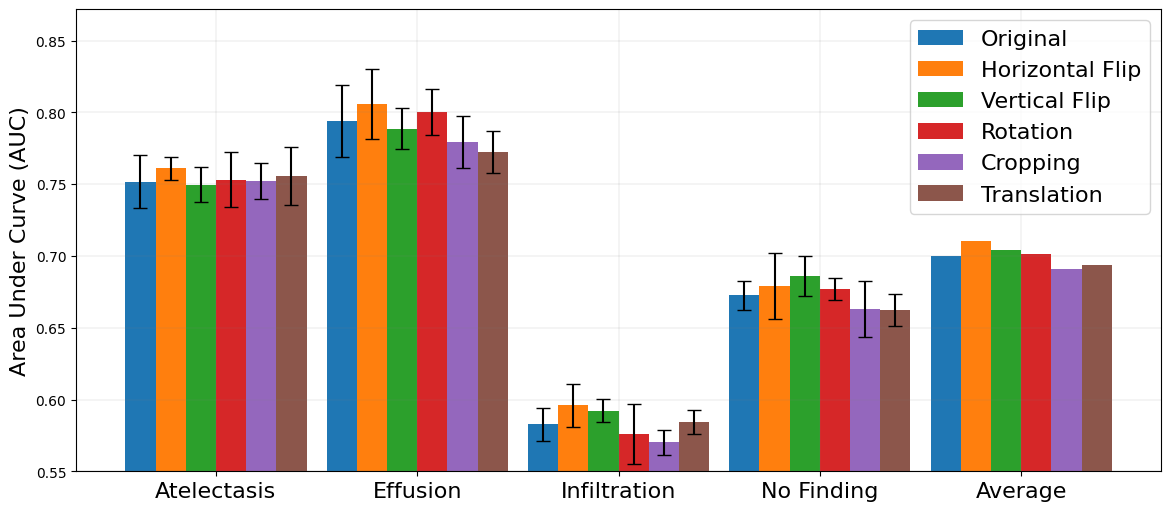

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

original_at, original_ef, original_in, original_nf = [], [], [], []
for eval in evaluations_original.values():
    original_at.append(eval[0][0])
    original_ef.append(eval[0][1])
    original_in.append(eval[0][2])
    original_nf.append(eval[0][3])
original_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [original_at, original_ef, original_in, original_nf])}
original_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [original_at, original_ef, original_in, original_nf])}

horizontal_at, horizontal_ef, horizontal_in, horizontal_nf = [], [], [], []
for eval in evaluations_horizontal.values():
    horizontal_at.append(eval[0][0])
    horizontal_ef.append(eval[0][1])
    horizontal_in.append(eval[0][2])
    horizontal_nf.append(eval[0][3])
horizontal_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [horizontal_at, horizontal_ef, horizontal_in, horizontal_nf])}
horizontal_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [horizontal_at, horizontal_ef, horizontal_in, horizontal_nf])}

vertical_at, vertical_ef, vertical_in, vertical_nf = [], [], [], []
for eval in evaluations_vertical.values():
    vertical_at.append(eval[0][0])
    vertical_ef.append(eval[0][1])
    vertical_in.append(eval[0][2])
    vertical_nf.append(eval[0][3])
vertical_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [vertical_at, vertical_ef, vertical_in, vertical_nf])}
vertical_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [vertical_at, vertical_ef, vertical_in, vertical_nf])}

rotation_at, rotation_ef, rotation_in, rotation_nf = [], [], [], []
for eval in evaluations_rotation.values():
    rotation_at.append(eval[0][0])
    rotation_ef.append(eval[0][1])
    rotation_in.append(eval[0][2])
    rotation_nf.append(eval[0][3])
rotation_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [rotation_at, rotation_ef, rotation_in, rotation_nf])}
rotation_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [rotation_at, rotation_ef, rotation_in, rotation_nf])}

crop_at, crop_ef, crop_in, crop_nf = [], [], [], []
for eval in evaluations_crop.values():
    crop_at.append(eval[0][0])
    crop_ef.append(eval[0][1])
    crop_in.append(eval[0][2])
    crop_nf.append(eval[0][3])
crop_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [crop_at, crop_ef, crop_in, crop_nf])}
crop_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [crop_at, crop_ef, crop_in, crop_nf])}

translation_at, translation_ef, translation_in, translation_nf = [], [], [], []
for eval in evaluations_translation.values():
    translation_at.append(eval[0][0])
    translation_ef.append(eval[0][1])
    translation_in.append(eval[0][2])
    translation_nf.append(eval[0][3])
translation_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [translation_at, translation_ef, translation_in, translation_nf])}
translation_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [translation_at, translation_ef, translation_in, translation_nf])}

performance = np.array([[original_means['at'], original_means['ef'], original_means['in'], original_means['nf']],
                        [horizontal_means['at'], horizontal_means['ef'], horizontal_means['in'], horizontal_means['nf']],
                        [vertical_means['at'], vertical_means['ef'], vertical_means['in'], vertical_means['nf']],
                        [rotation_means['at'], rotation_means['ef'], rotation_means['in'], rotation_means['nf']],
                        [crop_means['at'], crop_means['ef'], crop_means['in'], crop_means['nf']],
                        [translation_means['at'], translation_means['ef'], translation_means['in'], translation_means['nf']]])
row_averages = np.mean(performance, axis=1)
performance = np.column_stack((performance, row_averages))

std_dev = np.array([[original_stds['at'], original_stds['ef'], original_stds['in'], original_stds['nf'], np.NaN],
                    [horizontal_stds['at'], horizontal_stds['ef'], horizontal_stds['in'], horizontal_stds['nf'], np.NaN],
                    [vertical_stds['at'], vertical_stds['ef'], vertical_stds['in'], vertical_stds['nf'], np.NaN],
                    [rotation_stds['at'], rotation_stds['ef'], rotation_stds['in'], rotation_stds['nf'], np.NaN],
                    [crop_stds['at'], crop_stds['ef'], crop_stds['in'], crop_stds['nf'], np.NaN],
                    [translation_stds['at'], translation_stds['ef'], translation_stds['in'], translation_stds['nf'], np.NaN]])

print(np.mean(list(original_stds.values())))
print(np.mean(list(horizontal_stds.values())))
print(np.mean(list(vertical_stds.values())))
print(np.mean(list(rotation_stds.values())))
print(np.mean(list(crop_stds.values())))

print()
print(row_averages)
print()

print(original_means)
print(horizontal_means)
print(vertical_means)
print(rotation_means)
print(crop_means)


labels = ['Atelectasis', 'Effusion', 'Infiltration', 'No Finding', 'Average']
model_names = ['Original', 'Horizontal Flip', 'Vertical Flip', 'Rotation', 'Cropping', 'Translation']
n_models = len(model_names)
n_labels = len(labels)

font_size = 16

x = np.arange(n_labels)  # positions of the labels
width = 0.15  # width of each bar, smaller to fit all models in each label group

# Create a plot
fig, ax = plt.subplots(figsize=(14, 6))

for i in range(n_models):
    ax.bar(x + i * width, performance[i], width, yerr=std_dev[i], label=model_names[i], capsize=5)

ax.set_xticks(x + width * (n_models - 1) / 2)  # Place the x-ticks in the middle of the grouped bars
ax.set_xticklabels(labels, fontsize=font_size)
ax.legend(fontsize=font_size, loc="upper right")
ax.set_ylim(0.55)
ax.set_ylabel("Area Under Curve (AUC)", fontsize=font_size)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

plt.savefig("evals/augmentation/geometricAll_20epochs_5runs_ES.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

0.016361846049542147
0.01044762323993037
0.01216855634031601
0.01604841154434274
0.01044762323993037

[0.70030358 0.71417384]

{'at': 0.7518330267886971, 'ef': 0.7940259150343184, 'in': 0.5827023237179487, 'nf': 0.6726530692402648}
{'at': 0.7626550620248099, 'ef': 0.8156209904109064, 'in': 0.5962096497252747, 'nf': 0.6822096566041971}
{'at': 0.7497129126880109, 'ef': 0.7886488256236156, 'in': 0.5922685672075321, 'nf': 0.6859707384131972}
{'at': 0.7532262446262908, 'ef': 0.8003861003861003, 'in': 0.5759005927340889, 'nf': 0.6769327516552577}
{'at': 0.7626550620248099, 'ef': 0.8156209904109064, 'in': 0.5962096497252747, 'nf': 0.6822096566041971}


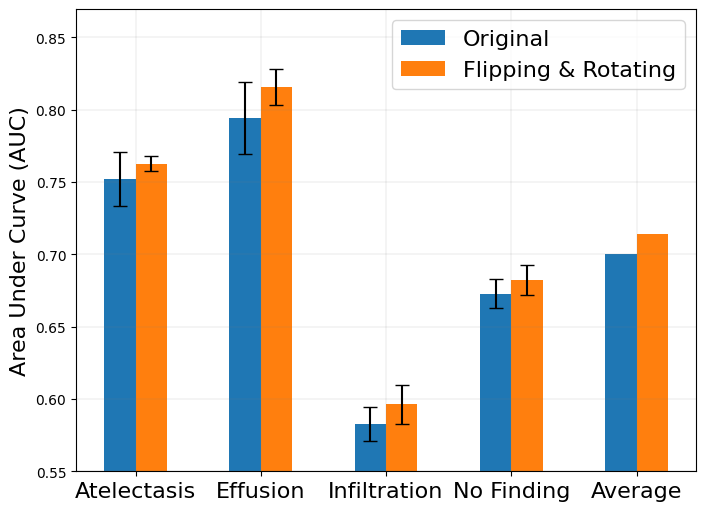

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

original_at, original_ef, original_in, original_nf = [], [], [], []
for eval in evaluations_original.values():
    original_at.append(eval[0][0])
    original_ef.append(eval[0][1])
    original_in.append(eval[0][2])
    original_nf.append(eval[0][3])
original_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [original_at, original_ef, original_in, original_nf])}
original_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [original_at, original_ef, original_in, original_nf])}

horizontal_at, horizontal_ef, horizontal_in, horizontal_nf = [], [], [], []
for eval in evaluations_all_geometric.values():
    horizontal_at.append(eval[0][0])
    horizontal_ef.append(eval[0][1])
    horizontal_in.append(eval[0][2])
    horizontal_nf.append(eval[0][3])
horizontal_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [horizontal_at, horizontal_ef, horizontal_in, horizontal_nf])}
horizontal_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [horizontal_at, horizontal_ef, horizontal_in, horizontal_nf])}

performance = np.array([[original_means['at'], original_means['ef'], original_means['in'], original_means['nf']],
                        [horizontal_means['at'], horizontal_means['ef'], horizontal_means['in'], horizontal_means['nf']]])
row_averages = np.mean(performance, axis=1)
performance = np.column_stack((performance, row_averages))

std_dev = np.array([[original_stds['at'], original_stds['ef'], original_stds['in'], original_stds['nf'], np.NaN],
                    [horizontal_stds['at'], horizontal_stds['ef'], horizontal_stds['in'], horizontal_stds['nf'], np.NaN]])

print(np.mean(list(original_stds.values())))
print(np.mean(list(horizontal_stds.values())))
print(np.mean(list(vertical_stds.values())))
print(np.mean(list(rotation_stds.values())))
print(np.mean(list(crop_stds.values())))

print()
print(row_averages)
print()

print(original_means)
print(horizontal_means)
print(vertical_means)
print(rotation_means)
print(crop_means)


labels = ['Atelectasis', 'Effusion', 'Infiltration', 'No Finding', 'Average']
model_names = ['Original', 'Flipping & Rotating']
n_models = len(model_names)
n_labels = len(labels)

font_size = 16

x = np.arange(n_labels)  # positions of the labels
width = 0.25  # width of each bar, smaller to fit all models in each label group

# Create a plot
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(n_models):
    ax.bar(x + i * width, performance[i], width, yerr=std_dev[i], label=model_names[i], capsize=5)

ax.set_xticks(x + width * (n_models - 1) / 2)  # Place the x-ticks in the middle of the grouped bars
ax.set_xticklabels(labels, fontsize=font_size)
ax.legend(fontsize=font_size, loc="upper right")
ax.set_ylim(0.55)
ax.set_ylabel("Area Under Curve (AUC)", fontsize=font_size)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

plt.savefig("evals/augmentation/geometricCombined_20epochs_5runs_ES.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

In [ ]:
with open(f"augmentation_data/images_test.pkl", "rb") as file:
    images_test = pickle.load(file)
with open(f"augmentation_data/labels_test.pkl", "rb") as file:
    labels_test = pickle.load(file)
    
master_evaluations = {}
BATCH_SIZE = 16
IMAGE_SIZE = 224



for aug_idx in range(4, 5):
    
    evaluations = {}
    
    images = None
    labels = None
    
    if aug_idx == 0:
        with open(f"augmentation_data/images_clean.pkl", "rb") as file:
            images = pickle.load(file)
        with open(f"augmentation_data/labels_clean.pkl", "rb") as file:
            labels = pickle.load(file)
    if aug_idx == 1:
        with open(f"augmentation_data/images_horizontal_flip.pkl", "rb") as file:
            images = pickle.load(file)
        with open(f"augmentation_data/labels_horizontal_flip.pkl", "rb") as file:
            labels = pickle.load(file)
    if aug_idx == 2:
        with open(f"augmentation_data/images_vertical_flip.pkl", "rb") as file:
            images = pickle.load(file)
        with open(f"augmentation_data/labels_vertical_flip.pkl", "rb") as file:
            labels = pickle.load(file)
    if aug_idx == 3:
        with open(f"augmentation_data/images_rotation.pkl", "rb") as file:
            images = pickle.load(file)
        with open(f"augmentation_data/labels_rotation.pkl", "rb") as file:
            labels = pickle.load(file)
    if aug_idx == 4:
        with open(f"augmentation_data/images_crop.pkl", "rb") as file:
            images = pickle.load(file)
        with open(f"augmentation_data/labels_crop.pkl", "rb") as file:
            labels = pickle.load(file)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for run, (train_idx, val_idx) in enumerate(skf.split(images, np.argmax(labels, axis=1))):
    
        tf.keras.backend.clear_session()
                
        images_train, images_val = images[train_idx], images[val_idx]
        labels_train, labels_val = labels[train_idx], labels[val_idx]
           
        train_dataset = create_train_dataset(images_train, labels_train)
        val_dataset = create_val_dataset(images_val, labels_val)
        
        steps_per_epoch = len(images_train) // BATCH_SIZE
        validation_steps = len(images_val) // BATCH_SIZE
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        reduceLR_callback = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=3,
            min_lr=1e-7
        )
        
        model = create_resnet_model(IMAGE_SIZE)
                    
        model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=50,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            batch_size=BATCH_SIZE,
            verbose=1,
            callbacks=[early_stopping, reduceLR_callback]) #######BIRNE
        
        sub_eval = evaluate_model(model, images_test, labels_test)
        
        evaluations[run] = sub_eval
        print(aug_idx)
        print(evaluations)
        
    master_evaluations[aug_idx] = evaluations